<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/Clean_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
!pip install tf-keras-vis

In [3]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from keras.models import Model


## Data Loading

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle-2.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle-2.json': No such file or directory
ref                                                           title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
spypsc07/amazon-products                                      Amazon_products                                    6KB  2024-08-02 06:13:47           1445         22  1.0              
berkayalan/paris-2024-olympics-medals                         Paris 2024 Olympics Medals                         1KB  2024-08-14 11:02:45           2770         52  1.0              
balajivaraprasad/crimes-against-women-in-india-2001-2021      Crimes Against Women in India (2001-2021)         13KB  2024-08-15 16:47:18            845    

In [4]:
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.44G/1.45G [00:12<00:00, 125MB/s]
100% 1.45G/1.45G [00:12<00:00, 124MB/s]


In [5]:
  ! unzip wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

In [6]:
'''''''''''###### SAME DATA LOADING CODE AS ABOVE
# Set the directory paths
train_dir = '/content/train'  # Adjust this path if necessary
valid_dir = '/content/valid'  # Adjust this path if necessary

# Prepare lists to store images and labels
x_train = []
y_train = []
x_valid = []
y_valid = []

# Function to load and process images
def load_dataset(dir_path, x_list, y_list):
    for direct in os.listdir(dir_path):
        print(f"Loading dataset from directory: {direct}")
        class_dir = os.path.join(dir_path, direct)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize image
                img = img / 255.0  # Normalize image
                x_list.append(img)
                y_list.append(direct)  # Add the label (directory name as class)
            else:
                print(f"Could not read image: {img_path}")

# Load training data
load_dataset(train_dir, x_train, y_train)

# Load validation data
load_dataset(valid_dir, x_valid, y_valid)

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_valid.shape}")
'''''''''''

Loading dataset from directory: nowildfire
Loading dataset from directory: wildfire
Loading dataset from directory: nowildfire
Loading dataset from directory: wildfire
Training data shape: (30250, 64, 64, 3)
Validation data shape: (6300, 64, 64, 3)


In [7]:
'''# Convert labels to numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_valid_onehot = onehot_encoder.transform(y_valid_encoded.reshape(-1, 1))

print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Validation labels shape: {y_valid_onehot.shape}")'''

Training labels shape: (30250, 2)
Validation labels shape: (6300, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Model

In [10]:
# Load the ResNet50 model, pretrained on ImageNet, excluding the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers to retain the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(64, activation='relu')(x)  # Add a Dense layer
x = Dropout(0.5)(x)

# Output layer for binary classification
output_layer = Dense(2, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
#model.summary()

# Train the model
#history = model.fit(train_data, epochs=20, validation_data=val_data)
#history = model.fit(
    #x_train, y_train_onehot,
    #validation_data=(x_valid, y_valid_onehot),
    #epochs=15,
    #batch_size=32
#)

# Unfreeze some layers of the base model and fine-tune
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,718,978 (90.48 MB)

 Trainable params: 4,596,930 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [12]:
# Continue fine-tuning the model
history_finetune = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    epochs=5,
    batch_size=32
)

Epoch 1/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7170 - loss: 0.6751 - val_accuracy: 0.8632 - val_loss: 0.3183
Epoch 2/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8309 - loss: 0.4036 - val_accuracy: 0.8740 - val_loss: 0.3032
Epoch 3/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8600 - loss: 0.3511 - val_accuracy: 0.8913 - val_loss: 0.2881
Epoch 4/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8674 - loss: 0.3307 - val_accuracy: 0.8944 - val_loss: 0.2678
Epoch 5/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8706 - loss: 0.3152 - val_accuracy: 0.8914 - val_loss: 0.2844


In [13]:
model.save('actual_fine_tuned_model.keras')

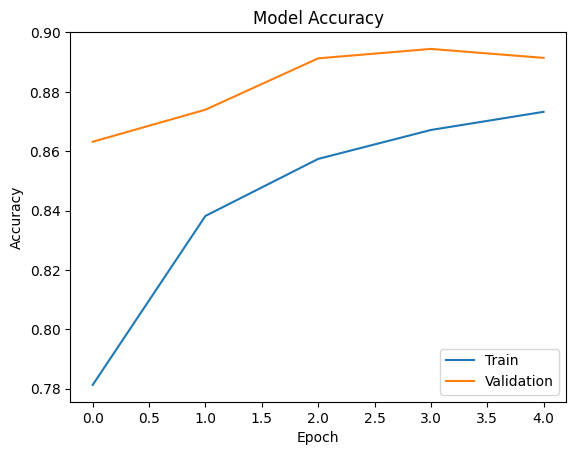

In [14]:
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

## Test Snippets

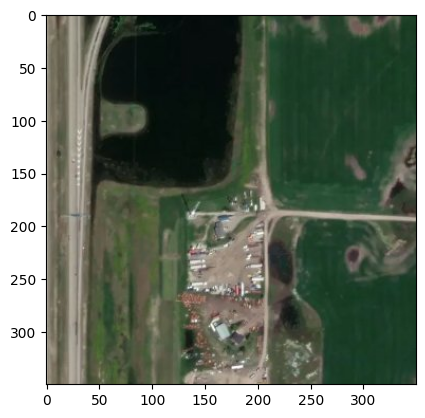

In [27]:
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/valid/nowildfire/-113.917791,51.148185.jpg" #nowildire
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
#plt.xlabel("No Wildfire")
plt.show()

In [28]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(64,64))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,64,64,3)
test_arr.append(test_image)

In [29]:
model.predict(test_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[0.8376804, 0.7580309]], dtype=float32)

In [19]:
# Predict classes for validation data
y_pred = model.predict(x_valid)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_valid_encoded, y_pred_classes)

print(cm)

197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
[[2536  284]
 [ 400 3080]]


In [20]:
# Step 1: Make predictions on the test set
y_pred = model.predict(x_train)  # Replace x_test with your actual test data

# Step 2: Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Compute accuracy by comparing the predicted labels with the true labels
accuracy = accuracy_score(y_train_encoded, y_pred_classes)  # Replace y_test_encoded with your actual test labels

# Print the accuracy
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
Test Set Accuracy: 89.67%


## GradCAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class index: 0


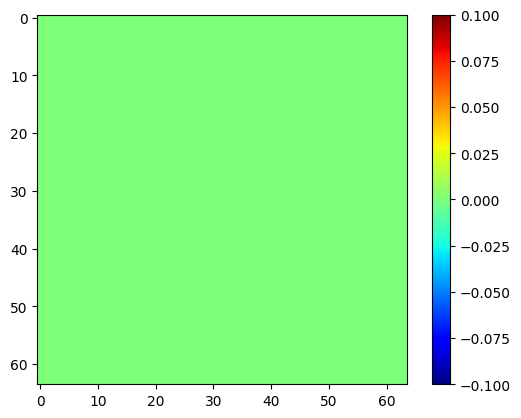

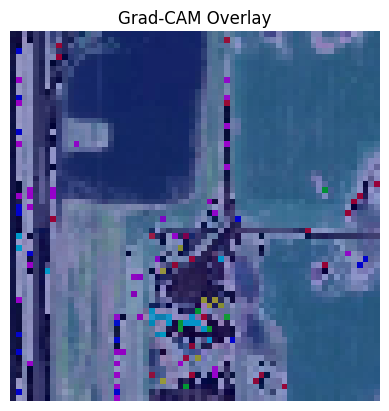

In [30]:
# Load and preprocess test image (example image from your dataset)
#test_img_path = "/content/Screenshot 2024-08-19 at 16.23.17.png"
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image, (64, 64))  # ResNet50 expects 224x224 images
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Preprocess the image using the ResNet50 preprocess_input function
test_image = preprocess_input(test_image)  # This function scales and centers the image using ImageNet stats
test_image_arr = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Run model predictions
preds = model.predict(test_image_arr)
predicted_class = np.argmax(preds, axis=-1)
predicted_class = predicted_class.item()  # Convert NumPy array to integer
print(f"Predicted class index: {predicted_class}")

# Now apply Grad-CAM using the keras-vis library
gradcam = Gradcam(model, model_modifier=None, clone=True)

# Define the target class score for Grad-CAM (use the predicted class)
score = CategoricalScore([predicted_class])

# Generate Grad-CAM heatmap
heatmap = gradcam(score, test_image_arr)

# Display the heatmap
plt.imshow(heatmap[0], cmap='jet')
plt.colorbar()
plt.show()

### Include the following code block right after displaying the heatmap ###

# Apply color map to the heatmap (optional, to visualize better)
heatmap_resized = cv2.resize(heatmap[0], (64, 64))  # Resize heatmap to original image size
heatmap_resized_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Ensure the original image is in the correct format (values between 0 and 255)
test_image_uint8 = np.uint8(255 * (test_image / np.max(test_image)))  # Convert to uint8 for blending

# Overlay Grad-CAM on the original image (use cv2.addWeighted)
overlayed_image = cv2.addWeighted(test_image_uint8, 0.6, heatmap_resized_colored, 0.4, 0)

# Display the overlayed image
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM Overlay')
plt.axis('off')
plt.show()


# Second Try

## Data Loading

In [31]:
###### SAME DATA LOADING CODE AS ABOVE
# Set the directory paths
train_dir = '/content/train'  # Adjust this path if necessary
valid_dir = '/content/valid'  # Adjust this path if necessary

# Prepare lists to store images and labels
x_train = []
y_train = []
x_valid = []
y_valid = []

# Function to load and process images
def load_dataset(dir_path, x_list, y_list):
    for direct in os.listdir(dir_path):
        print(f"Loading dataset from directory: {direct}")
        class_dir = os.path.join(dir_path, direct)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize image
                img = img / 255.0  # Normalize image
                x_list.append(img)
                y_list.append(direct)  # Add the label (directory name as class)
            else:
                print(f"Could not read image: {img_path}")

# Load training data
load_dataset(train_dir, x_train, y_train)

# Load validation data
load_dataset(valid_dir, x_valid, y_valid)

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_valid.shape}")


Loading dataset from directory: nowildfire
Loading dataset from directory: wildfire
Loading dataset from directory: nowildfire
Loading dataset from directory: wildfire
Training data shape: (30250, 224, 224, 3)
Validation data shape: (6300, 224, 224, 3)


In [32]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_valid_onehot = onehot_encoder.transform(y_valid_encoded.reshape(-1, 1))

print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Validation labels shape: {y_valid_onehot.shape}")

Training labels shape: (30250, 2)
Validation labels shape: (6300, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Model

In [4]:
# Load the ResNet50 model, pretrained on ImageNet, excluding the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(128, activation='relu')(x)  # Add a Dense layer
x = Dropout(0.5)(x)

# Output layer for binary classification
output_layer = Dense(2, activation='softmax')(x)

# Create the full model
model2 = Model(inputs=base_model.input, outputs=output_layer)

# Unfreeze some layers of the base model and fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model2.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 9,193,858 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [6]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/valid',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with early stopping
history_finetune2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)
'''

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 775/1891 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - accuracy: 0.8212 - loss: 0.4241

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  OSError: image file is truncated (16 bytes not processed)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 2156, in resize
    self.load()

  File "/usr/local/lib/python3.10/dist-packages/PIL/ImageFile.py", line 266, in load
    raise OSError(msg)

OSError: image file is truncated (16 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  OSError: image file is truncated (16 bytes not processed)
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 292, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 2156, in resize
    self.load()

  File "/usr/local/lib/python3.10/dist-packages/PIL/ImageFile.py", line 266, in load
    raise OSError(msg)

OSError: image file is truncated (16 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_15464]

In [7]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping

class CustomDataGenerator(Sequence):
    def __init__(self, directory, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle

        self.classes = sorted(os.listdir(directory))
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths, self.labels = self._get_image_paths_and_labels()

        self.on_epoch_end()  # Shuffle the data if necessary

    def _get_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for cls in self.classes:
            cls_dir = os.path.join(self.directory, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.startswith('.'):  # Skip hidden files
                    continue
                image_paths.append(os.path.join(cls_dir, img_name))
                labels.append(self.class_indices[cls])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([self._load_image_opencv(img_path) for img_path in batch_image_paths])
        labels = np.array(batch_labels)

        if self.class_mode == 'categorical':
            labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.classes))

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)
            self.image_paths = list(self.image_paths)
            self.labels = list(self.labels)

    def _load_image_opencv(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, self.target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize the image
        return img

# Usage:
train_generator = CustomDataGenerator('/content/train', batch_size=16, target_size=(224, 224))
val_generator = CustomDataGenerator('/content/valid', batch_size=16, target_size=(224, 224))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_finetune2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 89s 41ms/step - accuracy: 0.8865 - loss: 0.2811 - val_accuracy: 0.8879 - val_loss: 0.2979
Epoch 2/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9024 - loss: 0.2463 - val_accuracy: 0.8930 - val_loss: 0.2484
Epoch 3/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9130 - loss: 0.2288 - val_accuracy: 0.8621 - val_loss: 0.3340
Epoch 4/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9191 - loss: 0.2082 - val_accuracy: 0.9097 - val_loss: 0.2300
Epoch 5/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9240 - loss: 0.2031 - val_accuracy: 0.9216 - val_loss: 0.1996
Epoch 6/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - accuracy: 0.9277 - loss: 0.1861 - val_accuracy: 0.8712 - val_loss: 0.3282
Epoch 7/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - accuracy: 0.9308 - loss: 0.1813 - val_accuracy: 0.9082 - val_loss: 0.2486
Epoch 8/30
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - accuracy: 0.9341 - loss: 0.17

In [ ]:
'''

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with early stopping
history_finetune2 = model2.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    epochs=30,  # Maximum number of epochs
    batch_size=32,
    callbacks=[early_stopping]'''
)

In [9]:
model2.save('resent50_finetuned_224.keras')

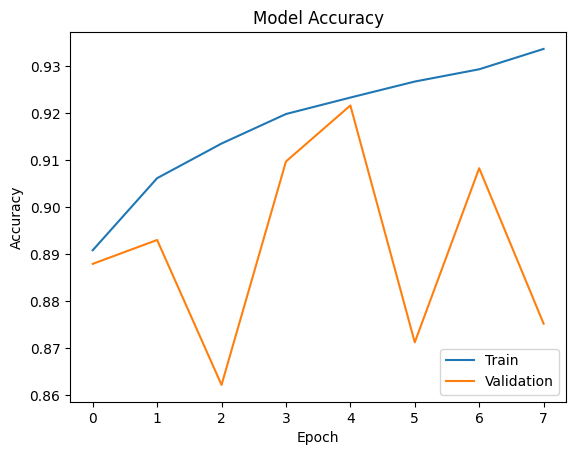

In [10]:
plt.plot(history_finetune2.history['accuracy'])
plt.plot(history_finetune2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [ ]:
'''# Continue fine-tuning the model
history_finetune = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),
    epochs=10,
    batch_size=32
)'''

## Tests

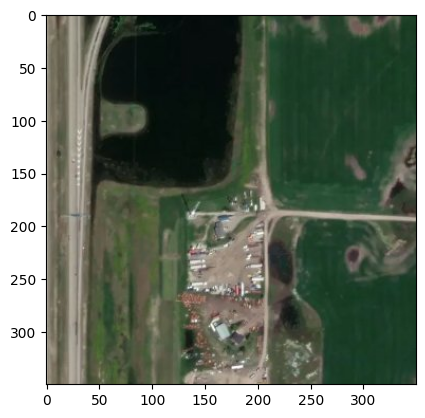

In [11]:
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/valid/nowildfire/-113.917791,51.148185.jpg" #nowildire
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
#plt.xlabel("No Wildfire")
plt.show()

In [12]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(224,224))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,224,224,3)
test_arr.append(test_image)

In [13]:
model2.predict(test_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.9969825 , 0.00301745]], dtype=float32)

In [15]:
# Step 1: Predict classes for the validation data using the generator
y_pred = model2.predict(val_generator, steps=len(val_generator))

# Step 2: Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Get true labels from the validation generator
# Note: val_generator.labels is not directly available in CustomDataGenerator,
# so we have to accumulate them manually from the generator
y_true = []
for _, labels in val_generator:
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= len(val_generator.labels):  # Break when we have enough labels
        break

y_true = np.array(y_true[:len(y_pred_classes)])  # Ensure lengths match

# Step 4: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

print(cm)

393/393 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step
[[1150 1666]
 [1482 1990]]


In [16]:
from sklearn.metrics import accuracy_score

# Step 1: Convert the predicted probabilities to class labels (assuming y_pred is already available)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 2: Compute accuracy by comparing the predicted labels with the true labels (assuming y_true is already available)
accuracy = accuracy_score(y_true, y_pred_classes)

# Print the accuracy
print(f"Training Set Accuracy: {accuracy * 100:.2f}%")

Training Set Accuracy: 49.94%


In [17]:
# Use model2.evaluate() to compute accuracy on the training set
train_accuracy = model2.evaluate(train_generator, steps=len(train_generator))

# Print the training accuracy
print(f"Training Set Accuracy (from Keras): {train_accuracy[1] * 100:.2f}%")


1890/1890 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.9218 - loss: 0.2005
Training Set Accuracy (from Keras): 92.44%


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize lists to gather true labels and predicted labels
y_true = []
y_pred_classes = []

# Step 1: Loop through the validation generator batch by batch
for i in range(len(val_generator)):
    # Get a batch of data from the generator
    images, labels = val_generator[i]

    # Get model predictions for this batch
    y_pred_batch = model2.predict(images)

    # Convert predicted probabilities to class labels
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

    # Convert true labels from one-hot encoding to class indices
    y_true_batch = np.argmax(labels, axis=1)

    # Append results to the lists
    y_true.extend(y_true_batch)
    y_pred_classes.extend(y_pred_classes_batch)

# Convert lists to numpy arrays for consistency
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

## GradCAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class index: 0


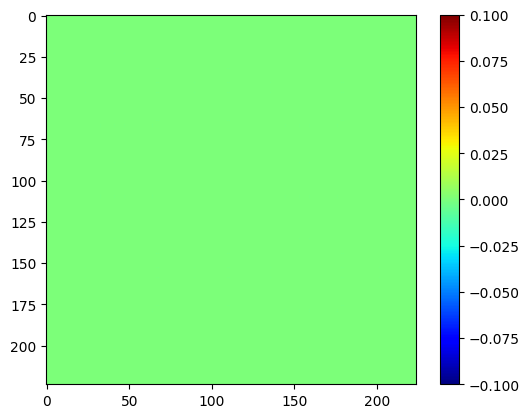

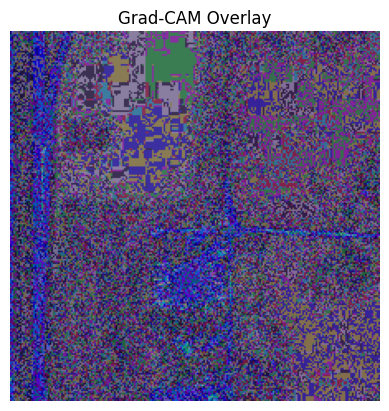

In [23]:
# Load and preprocess test image (example image from your dataset)
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image, (224, 224))  # ResNet50 expects 224x224 images
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Preprocess the image using the ResNet50 preprocess_input function
test_image = preprocess_input(test_image)  # This function scales and centers the image using ImageNet stats
test_image_arr = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Run model predictions
preds = model2.predict(test_image_arr)
predicted_class = np.argmax(preds, axis=-1)[0]
print(f"Predicted class index: {predicted_class}")

# Verify and set the last convolutional layer manually (e.g., conv5_block3_out)
last_conv_layer_name = 'conv5_block3_out'  # Replace with actual layer name from model summary

# Now apply Grad-CAM using the keras-vis library, specifying the last convolutional layer
gradcam = Gradcam(model2, model_modifier=None, clone=True)

# Define the target class score for Grad-CAM (use the predicted class)
score = CategoricalScore([predicted_class])

# Generate Grad-CAM heatmap using the last convolutional layer
heatmap = gradcam(score, test_image_arr, penultimate_layer=last_conv_layer_name)

# Display the heatmap
plt.imshow(heatmap[0], cmap='jet')
plt.colorbar()
plt.show()

### Continue with the following code ###

# Apply color map to the heatmap (optional, to visualize better)
heatmap_resized = cv2.resize(heatmap[0], (224, 224))  # Resize heatmap to original image size
heatmap_resized_colored = cv2.applyColorMap(np.uint8(255 * np.clip(heatmap_resized, 0, 1)), cv2.COLORMAP_JET)

# Convert the preprocessed image back to the original format [0, 255]
# ResNet50 preprocess_input scales to [-1, 1], so reverse it
test_image_uint8 = np.uint8((test_image + 1) * 127.5)  # Convert back from [-1, 1] to [0, 255]

# Overlay Grad-CAM on the original image (use cv2.addWeighted)
overlayed_image = cv2.addWeighted(test_image_uint8, 0.6, heatmap_resized_colored, 0.4, 0)

# Display the overlayed image
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM Overlay')
plt.axis('off')
plt.show()


In [24]:
import tensorflow as tf

def check_gradients(model, img_array, class_idx, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Compute the gradient of the loss w.r.t the output feature map
    grads = tape.gradient(loss, conv_outputs)

    # Inspect the gradient values
    if grads is not None:
        print("Gradient min:", tf.reduce_min(grads).numpy())
        print("Gradient max:", tf.reduce_max(grads).numpy())
        print("Gradient mean:", tf.reduce_mean(grads).numpy())
    else:
        print("No gradients found.")


In [26]:
check_gradients(model2, test_image_arr, predicted_class, 'conv4_block6_out')


Gradient min: -0.0020411983
Gradient max: 0.0020837658
Gradient mean: 6.82152e-07
